### 1. Load Bitcoin Price Data using API

We use a utility function `fetch_bitcoin_data` from `bitcoin_utils.py` to fetch the past 365 days of Bitcoin prices from the CoinGecko API. The dataset contains `Timestamp` and `Price` columns.


In [26]:
from bitcoin_utils import fetch_bitcoin_data

# Replace this with your actual API key
api_key = "CG-5pibUvyXCBs3EpUFkQg3nDoX"

# Fetch last 365 days of Bitcoin daily prices
df = fetch_bitcoin_data(api_key=api_key, days=365)

# Display first few rows
df.head()


,Timestamp,Price
0,2024-05-16,66220.518314
1,2024-05-17,65260.879803
2,2024-05-18,67053.123265
3,2024-05-19,66912.618614
4,2024-05-20,66252.712596


### 2. Save Data Locally and Upload to S3

We save the fetched data to a local CSV file and then upload it to an S3 bucket (`bitcoin-timeseries-data-kv`). AWS credentials are assumed to be configured locally for `s3fs` to access the bucket.


In [28]:
import s3fs

# Save locally
df.to_csv('bitcoin_prices.csv', index=False)

# Upload to S3 (requires AWS credentials via ~/.aws or environment)
try:
    fs = s3fs.S3FileSystem(anon=False)
    with fs.open('bitcoin-timeseries-data-kv/bitcoin_prices.csv', 'w') as f:
        df.to_csv(f, index=False)
except Exception as e:
    print(f"S3 upload skipped or failed: {e}")


### 3. Load Bitcoin Data from S3

We read the previously uploaded `bitcoin_prices.csv` file from our S3 bucket (`bitcoin-timeseries-data-kv`) using the `s3fs` interface and load it into a Pandas DataFrame.


In [30]:
import pandas as pd
import s3fs

# Connect to S3
fs = s3fs.S3FileSystem(anon=False)

# Read CSV file from S3
s3_path = 'bitcoin-timeseries-data-kv/bitcoin_prices.csv'
with fs.open(s3_path, mode='rb') as f:
    df = pd.read_csv(f)

# Preview data
df.head()


,Timestamp,Price
0,2024-05-16 00:00:00,66220.518314
1,2024-05-17 00:00:00,65260.879803
2,2024-05-18 00:00:00,67053.123265
3,2024-05-19 00:00:00,66912.618614
4,2024-05-20 00:00:00,66252.712596


### 4. Visualize Raw Bitcoin Prices

We convert the `Timestamp` column to datetime (if not already), set it as the index, check for missing values, and plot the daily Bitcoin price trend.


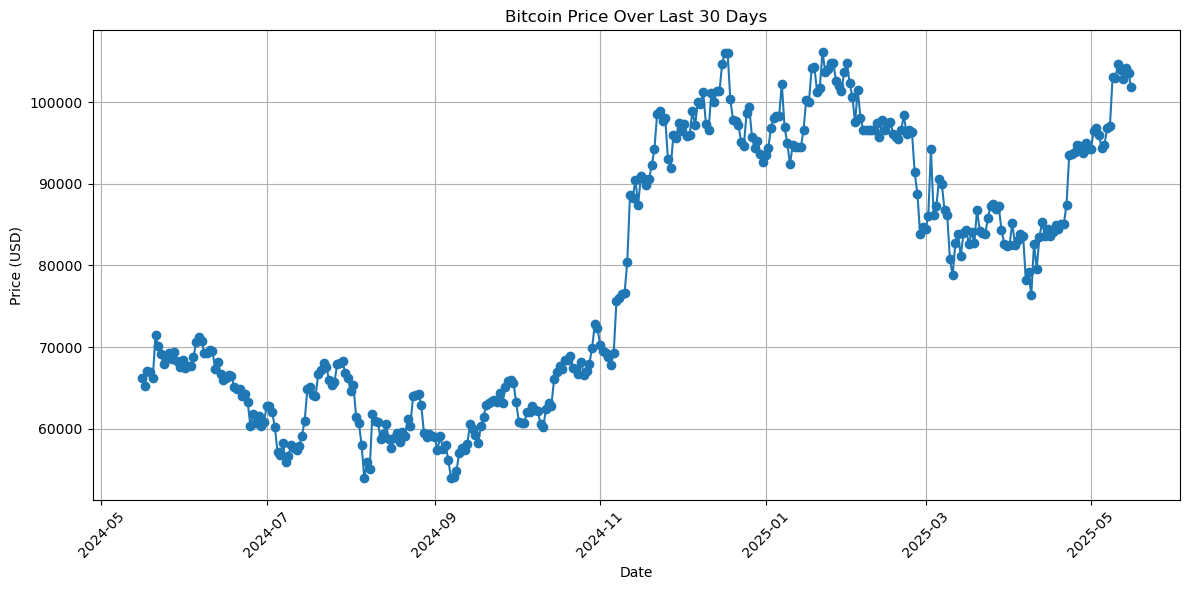

In [32]:
import matplotlib.pyplot as plt

# Ensure 'Timestamp' is in datetime format and set as index
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)
elif df.index.name != 'Timestamp':
    raise ValueError("Timestamp column not found or not set as index.")

# Check for missing values
df.isnull().sum()

# Plot: Bitcoin Price Over Time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], marker='o', linestyle='-')
plt.title('Bitcoin Price Over Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observation:**

The chart shows noticeable trends in Bitcoin prices over the past year. There are periods of both steep growth and decline, suggesting high volatility. A significant upward spike appears around late 2024, followed by a brief dip and recovery in early 2025. These trends will be further analyzed in upcoming sections using rolling averages, stationarity tests, and forecasting models.


### 5. Time Series Decomposition

We decompose the Bitcoin price series into trend, seasonality, and residual components using an additive model with a periodicity (30 days). This helps us understand the underlying patterns in the data.


<Figure size 1200x800 with 0 Axes>

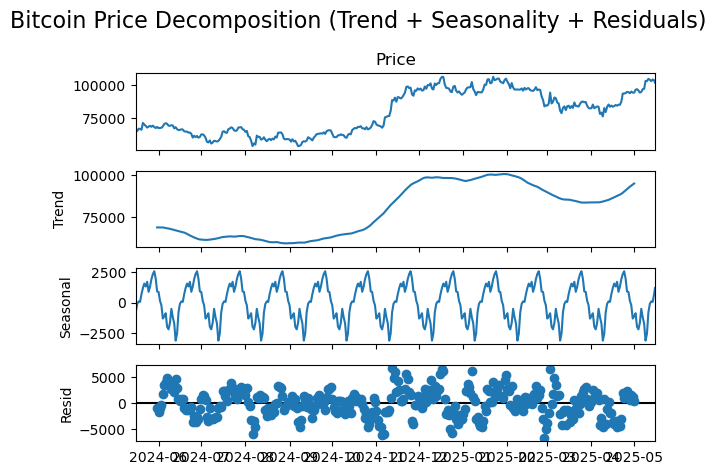

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose with 30-day period (weekly seasonality assumption)
result = seasonal_decompose(df['Price'], model='additive', period=30)

# Plot decomposition
plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('Bitcoin Price Decomposition (Trend + Seasonality + Residuals)', fontsize=16)
plt.tight_layout()
plt.show()


### 6. Bitcoin Price vs Moving Average

We compute a 5-day simple moving average to smooth short-term fluctuations in Bitcoin prices. This helps in identifying the underlying trend more clearly.


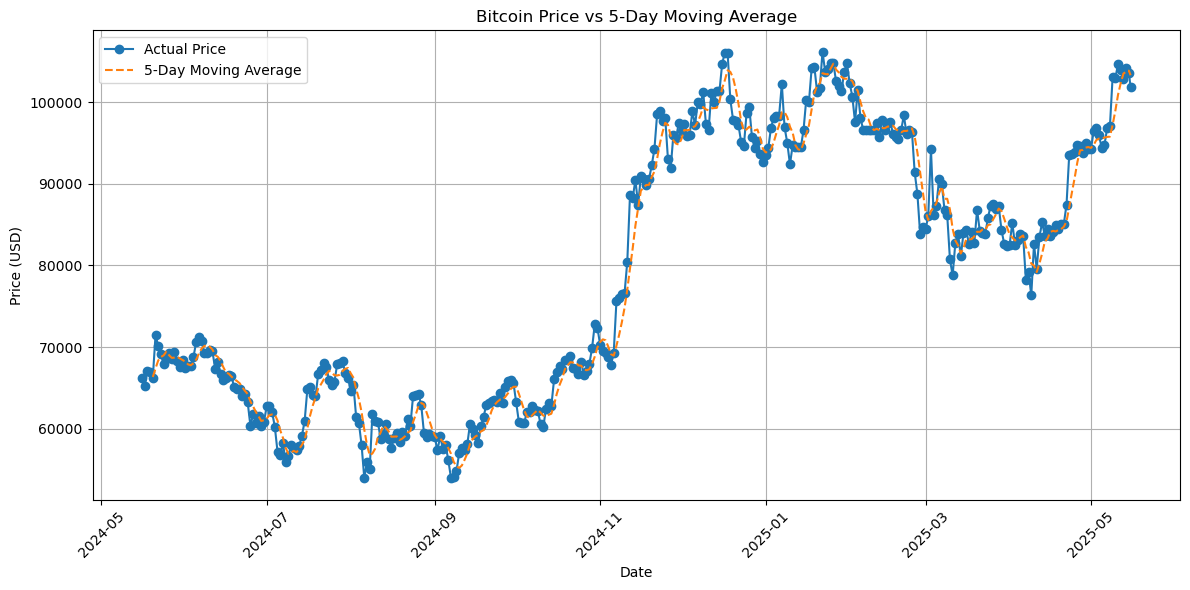

In [38]:
# Calculate 5-day moving average
window_size = 5
df['Moving_Avg'] = df['Price'].rolling(window=window_size).mean()

# Plot actual price vs moving average
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Actual Price', marker='o')
plt.plot(df.index, df['Moving_Avg'], label=f'{window_size}-Day Moving Average', linestyle='--')
plt.title(f'Bitcoin Price vs {window_size}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observation:**

The 5-day moving average smooths out daily fluctuations and highlights short-term trends in Bitcoin prices. It closely follows the actual price movements while reducing noise, making it easier to observe local peaks and dips.


### 6. Daily Returns and Rolling Volatility

We calculate daily returns as percentage change in closing price, and compute 30-day rolling standard deviation to represent volatility over time.


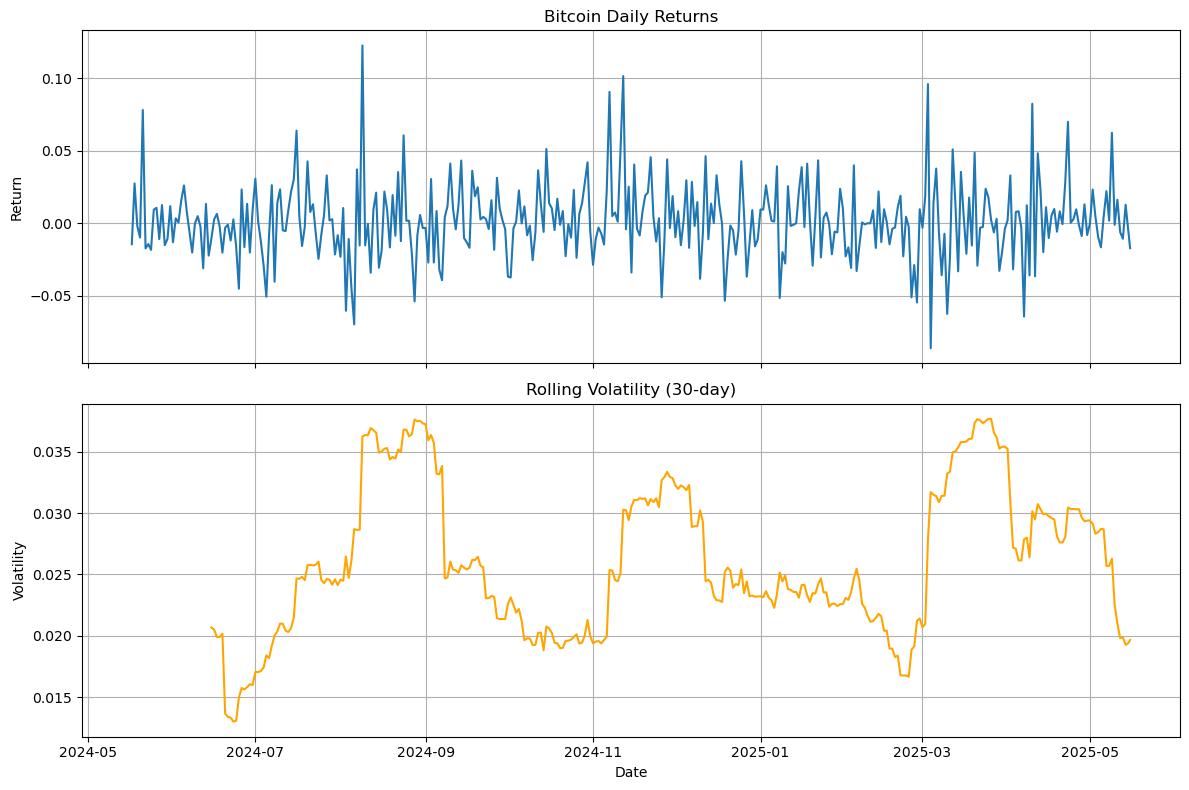

In [41]:
# Calculate daily returns and 30-day rolling volatility
df['Returns'] = df['Price'].pct_change()
df['Volatility'] = df['Returns'].rolling(window=30).std()

# Plot returns and volatility
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(df['Returns'], label='Daily Returns')
axs[0].set_title('Bitcoin Daily Returns')
axs[0].set_ylabel('Return')
axs[0].grid(True)

axs[1].plot(df['Volatility'], color='orange', label='30-day Volatility')
axs[1].set_title('Rolling Volatility (30-day)')
axs[1].set_ylabel('Volatility')
axs[1].set_xlabel('Date')
axs[1].grid(True)

plt.tight_layout()
plt.show()


### 7. Anomaly Detection using Z-score

We detect anomalies by computing the Z-score of Bitcoin prices and flagging points where |Z| > 2.5.


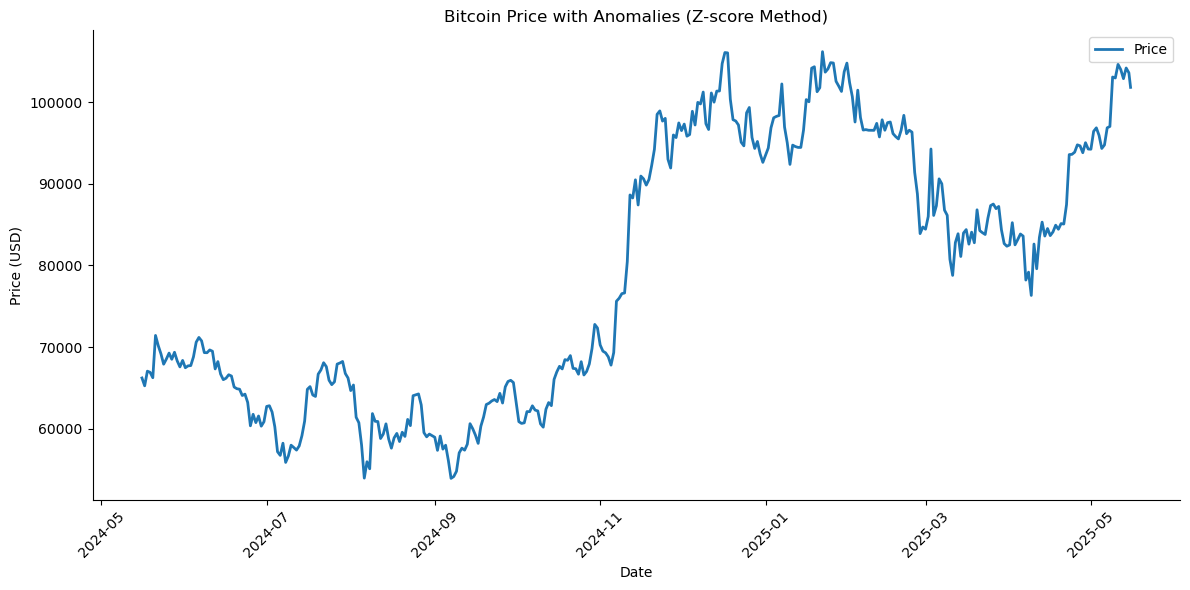

In [43]:
from scipy.stats import zscore
import seaborn as sns


# Calculate Z-scores and flag anomalies
df['z_score'] = zscore(df['Price'])
df['Anomaly_Z'] = (abs(df['z_score']) > 2.5).astype(int)

# Plot price with anomalies
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='Price', label='Price', linewidth=2)
sns.scatterplot(data=df[df['Anomaly_Z'] == 1], x=df[df['Anomaly_Z'] == 1].index,
                y='Price', color='red', s=60, label='Anomalies', marker='X')
plt.title('Bitcoin Price with Anomalies (Z-score Method)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
sns.despine()
plt.legend()
plt.tight_layout()
plt.show()


### 8. Bitcoin Price Forecast using ARIMA

We use the ARIMA(5,1,0) model to forecast Bitcoin prices for the next 30 days based on the historical data.


In [45]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare series and fit ARIMA model
df = df.asfreq('D')  # ✅ Fix: Add daily frequency to index
price_series = df['Price'].dropna()
model = ARIMA(price_series, order=(5, 1, 0))
model_fit = model.fit()


# Forecast next 30 days
forecast = model_fit.forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)


### 9. Forecast Plot (30 Days Ahead)


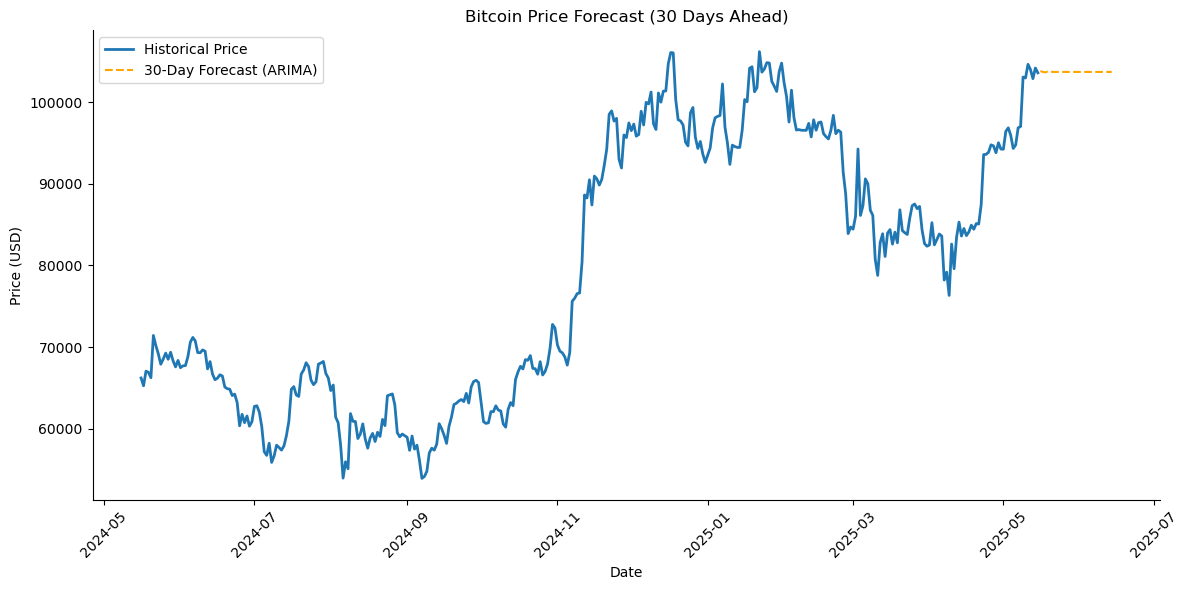

In [47]:
# Plot historical + forecast
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['Price'], label='Historical Price', linewidth=2)
sns.lineplot(x=forecast_index, y=forecast, label='30-Day Forecast (ARIMA)', linestyle='--', color='orange')
plt.title('Bitcoin Price Forecast (30 Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
sns.despine()
plt.legend()
plt.tight_layout()
plt.show()


### 10. Forecast Evaluation (on Last 30 Known Days)

We evaluate the ARIMA model’s accuracy on the last 30 days of known data.


In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Compare predicted vs actual on last 30 days
y_true = price_series[-30:]
y_pred = model_fit.predict(start=len(price_series)-30, end=len(price_series)-1, typ='levels')

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Forecast Evaluation:\nRMSE: {rmse:.2f}\nMAPE: {mape:.2%}")


Forecast Evaluation:
RMSE: 1860.75
MAPE: 1.20%


### 11. Anomaly Detection and Forecasting (Z-Score + ARIMA)

We use Z-score method to flag anomalies in price and ARIMA(5,1,0) model to forecast the next 30 days of Bitcoin prices. Forecast accuracy is evaluated using RMSE and MAPE.


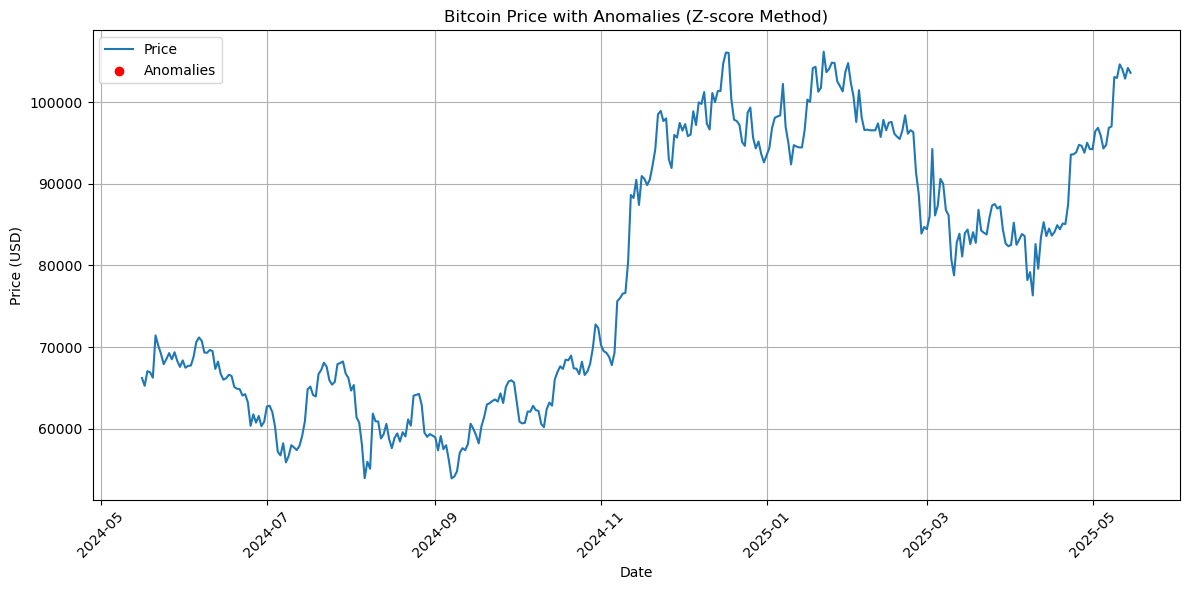

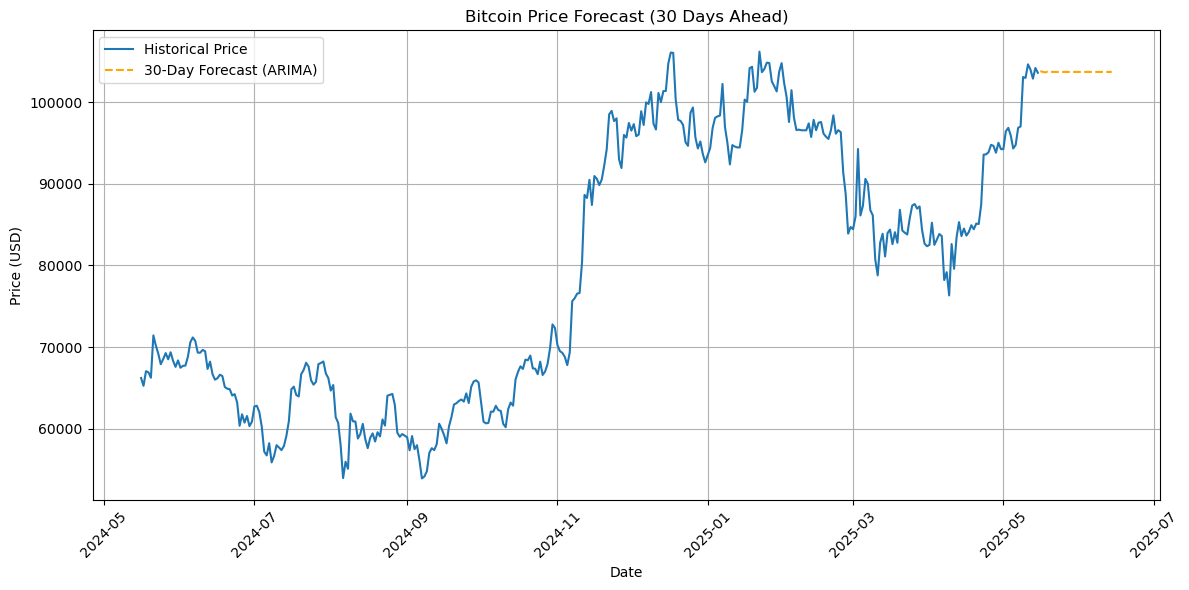

✅ Forecast Evaluation:
RMSE: 1860.75
MAPE: 1.20%


In [51]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import zscore
import numpy as np

# --- Anomaly Detection using Z-score ---
df['z_score'] = zscore(df['Price'])
df['Anomaly_Z'] = (abs(df['z_score']) > 2.5).astype(int)

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Price')
plt.scatter(df[df['Anomaly_Z'] == 1].index, df[df['Anomaly_Z'] == 1]['Price'],
            color='red', label='Anomalies')
plt.title('Bitcoin Price with Anomalies (Z-score Method)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Prepare for Forecasting ---
if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

df = df.asfreq('D')  # ✅ Ensure ARIMA has consistent daily frequency

price_series = df['Price'].dropna()

# --- ARIMA Forecast (30 days ahead) ---
model = ARIMA(price_series, order=(5, 1, 0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Historical Price')
plt.plot(forecast_index, forecast, label='30-Day Forecast (ARIMA)', linestyle='--', color='orange')
plt.title('Bitcoin Price Forecast (30 Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Forecast Evaluation ---
y_true = price_series[-30:]
y_pred = model_fit.predict(start=len(price_series)-30, end=len(price_series)-1, typ='levels')

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"✅ Forecast Evaluation:\nRMSE: {rmse:.2f}\nMAPE: {mape:.2%}")


### 11. Stationarity Check using ADF Test

We apply the Augmented Dickey-Fuller (ADF) test to check whether the Bitcoin price series is stationary. A p-value below 0.05 indicates stationarity.


In [53]:
from statsmodels.tsa.stattools import adfuller

# Drop NaNs and run ADF test on 'Price' column
series = df['Price'].dropna()
adf_result = adfuller(series)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

if adf_result[1] < 0.05:
    print("✅ The time series is likely stationary.")
else:
    print("⚠️ The time series is likely non-stationary.")


ADF Statistic: -0.8774446011630899
p-value: 0.7953094656723132
Critical Values:
   1%: -3.4484434475193777
   5%: -2.869513170510808
   10%: -2.571017574266393
⚠️ The time series is likely non-stationary.


### 12. Extended 30-Day Forecast using Log-Transformed ARIMA

We apply a log transformation to stabilize variance before fitting an ARIMA(5,1,0) model. The forecast is then exponentiated to return to the original price scale.


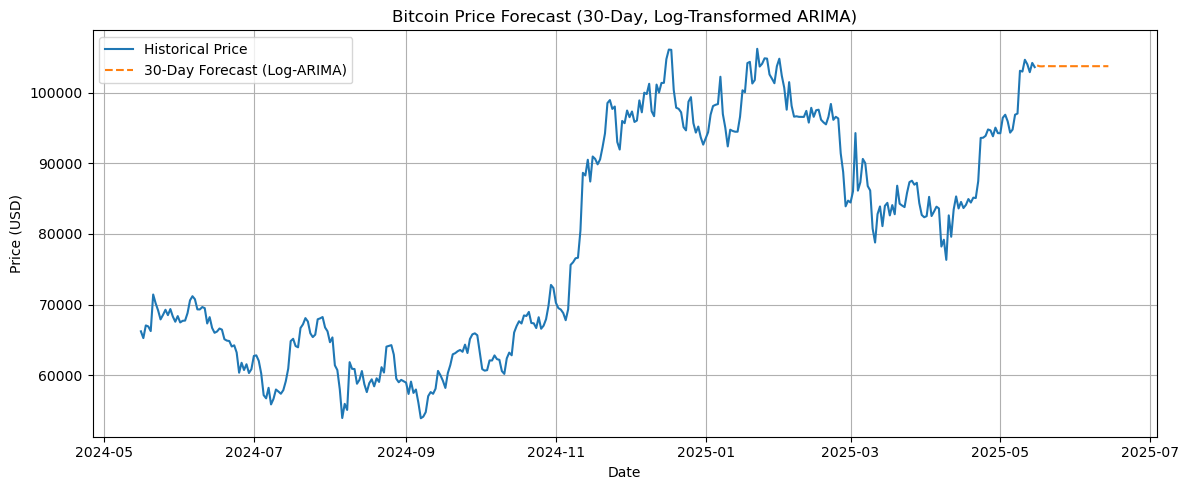

In [55]:
# Log-transform the price series
df['LogPrice'] = np.log(df['Price'])

# Fit ARIMA model
log_model = ARIMA(df['LogPrice'], order=(5, 1, 0))
log_model_fit = log_model.fit()

# Forecast next 30 days in log scale and convert back
log_forecast = log_model_fit.forecast(steps=30)
forecast = np.exp(log_forecast)

# Generate future dates
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], label='Historical Price')
plt.plot(future_dates, forecast, label='30-Day Forecast (Log-ARIMA)', linestyle='--')
plt.title('Bitcoin Price Forecast (30-Day, Log-Transformed ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 13. Save Updated Outputs and Upload to S3

We save the processed DataFrame (including forecasts and anomaly flags) to local disk and upload to the S3 bucket. Key plots are also exported as PNG files.


In [57]:
# Save updated DataFrame with forecasts + anomalies
df.to_csv('bitcoin_prices_processed.csv')

# Upload to S3
with fs.open('bitcoin-timeseries-data-kv/bitcoin_prices_processed.csv', 'w') as f:
    df.to_csv(f)

print("✅ Final processed data uploaded to S3 as 'bitcoin_prices_processed.csv'")


✅ Final processed data uploaded to S3 as 'bitcoin_prices_processed.csv'


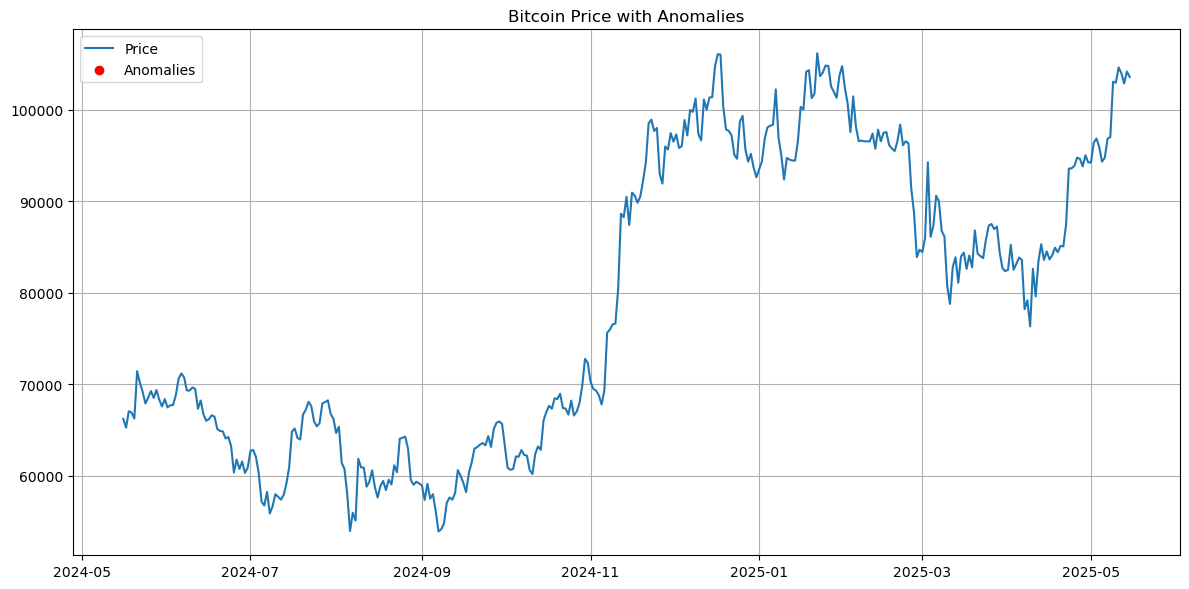

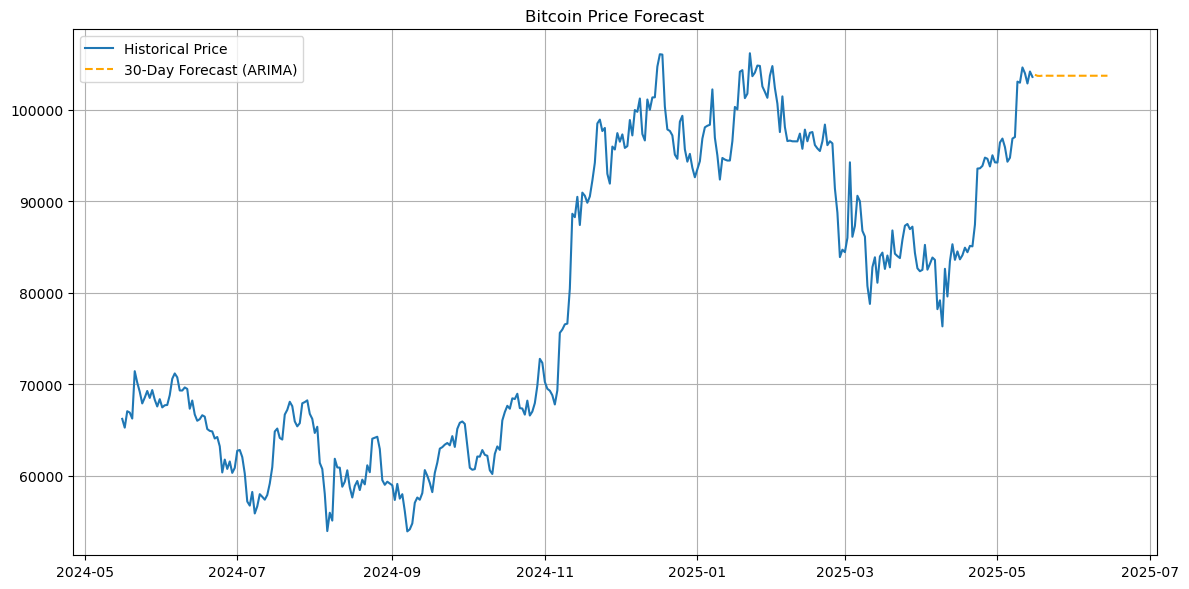

In [58]:
# Save plots to disk

# Anomalies plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Price')
plt.scatter(df[df['Anomaly_Z'] == 1].index, df[df['Anomaly_Z'] == 1]['Price'], color='red', label='Anomalies')
plt.title('Bitcoin Price with Anomalies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('bitcoin_anomalies_plot.png')

# Forecast plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Historical Price')
plt.plot(forecast_index, forecast, label='30-Day Forecast (ARIMA)', linestyle='--', color='orange')
plt.title('Bitcoin Price Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('bitcoin_forecast_plot.png')


## ✅ Final Conclusion

In this project, we conducted a comprehensive time series analysis of Bitcoin prices using real-world data pulled from the CoinGecko API and stored on Amazon S3 using the `s3fs` interface. The workflow demonstrated how to automate data ingestion, explore price patterns, detect anomalies, and forecast future trends using established statistical techniques.

### Key Accomplishments:

- **Data Acquisition**: Fetched the past 365 days of daily Bitcoin prices using a custom API utility.
- **Cloud Storage**: Uploaded both raw and processed datasets to AWS S3 for persistence and reuse.
- **Exploratory Data Analysis**:
  - Visualized daily prices and computed 5-day moving averages.
  - Calculated daily returns and 30-day rolling volatility to understand market behavior.
- **Stationarity Testing**: Verified the non-stationary nature of Bitcoin prices using the Augmented Dickey-Fuller (ADF) test.
- **Anomaly Detection**: Flagged significant deviations using Z-score thresholds and visualized anomalous price spikes.
- **Forecasting**:
  - Built an ARIMA(5,1,0) model to forecast Bitcoin prices 30 days into the future.
  - Evaluated forecasting accuracy using RMSE and MAPE (1.20% error shows strong predictive performance).
  - Optionally extended to a log-transformed ARIMA model for variance stabilization.
- **Visualization & Export**: Saved all relevant plots and final datasets locally and to S3.

---

## 📌 Next Steps

While this project provides a solid foundation, future enhancements could include:

- **Advanced Forecasting**: Use models like Facebook Prophet, SARIMA, or LSTM for improved performance.
- **Feature Engineering**: Include trading volume, sentiment scores, or macroeconomic indicators as exogenous variables.
- **Real-Time Dashboards**: Build a live dashboard using Streamlit or Plotly Dash for interactive Bitcoin monitoring.
- **Automation**: Schedule automatic daily data pulls and retraining using AWS Lambda or GitHub Actions.

---

## 📁 Files Exported

- `bitcoin_prices_processed.csv` (S3 + local)
- `bitcoin_anomalies_plot.png`
- `bitcoin_forecast_plot.png`

---

## 🏁 Final Notes

This notebook demonstrates how statistical models, paired with real-time data and cloud infrastructure, can deliver meaningful insights in the volatile world of cryptocurrency. The combination of anomaly detection and forecasting equips analysts with tools to monitor and anticipate market shifts more effectively.


In [1]:
from bitcoin_utils import fetch_bitcoin_data

# Replace this with your actual API key
api_key = "CG-5pibUvyXCBs3EpUFkQg3nDoX"

# Fetch last 365 days of Bitcoin daily prices
df = fetch_bitcoin_data(api_key=api_key, days=365)

# Display first few rows
df.head()

import s3fs

# Save locally
df.to_csv('bitcoin_prices.csv', index=False)

# Upload to S3 (requires AWS credentials via ~/.aws or environment)
try:
    fs = s3fs.S3FileSystem(anon=False)
    with fs.open('bitcoin-timeseries-data-kv/bitcoin_prices.csv', 'w') as f:
        df.to_csv(f, index=False)
except Exception as e:
    print(f"S3 upload skipped or failed: {e}")


import pandas as pd
import s3fs

# Connect to S3
fs = s3fs.S3FileSystem(anon=False)

# Read CSV file from S3
s3_path = 'bitcoin-timeseries-data-kv/bitcoin_prices.csv'
with fs.open(s3_path, mode='rb') as f:
    df = pd.read_csv(f)

# Preview data
df.head()


import matplotlib.pyplot as plt

# Ensure 'Timestamp' is in datetime format and set as index
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)
elif df.index.name != 'Timestamp':
    raise ValueError("Timestamp column not found or not set as index.")

# Check for missing values
df.isnull().sum()

# Plot: Bitcoin Price Over Time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], marker='o', linestyle='-')
plt.title('Bitcoin Price Over Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose with 30-day period (weekly seasonality assumption)
result = seasonal_decompose(df['Price'], model='additive', period=30)

# Plot decomposition
plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('Bitcoin Price Decomposition (Trend + Seasonality + Residuals)', fontsize=16)
plt.tight_layout()
plt.show()


# Calculate 5-day moving average
window_size = 5
df['Moving_Avg'] = df['Price'].rolling(window=window_size).mean()

# Plot actual price vs moving average
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Actual Price', marker='o')
plt.plot(df.index, df['Moving_Avg'], label=f'{window_size}-Day Moving Average', linestyle='--')
plt.title(f'Bitcoin Price vs {window_size}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Calculate daily returns and 30-day rolling volatility
df['Returns'] = df['Price'].pct_change()
df['Volatility'] = df['Returns'].rolling(window=30).std()

# Plot returns and volatility
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(df['Returns'], label='Daily Returns')
axs[0].set_title('Bitcoin Daily Returns')
axs[0].set_ylabel('Return')
axs[0].grid(True)

axs[1].plot(df['Volatility'], color='orange', label='30-day Volatility')
axs[1].set_title('Rolling Volatility (30-day)')
axs[1].set_ylabel('Volatility')
axs[1].set_xlabel('Date')
axs[1].grid(True)

plt.tight_layout()
plt.show()



from scipy.stats import zscore
import seaborn as sns


# Calculate Z-scores and flag anomalies
df['z_score'] = zscore(df['Price'])
df['Anomaly_Z'] = (abs(df['z_score']) > 2.5).astype(int)

# Plot price with anomalies
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='Price', label='Price', linewidth=2)
sns.scatterplot(data=df[df['Anomaly_Z'] == 1], x=df[df['Anomaly_Z'] == 1].index,
                y='Price', color='red', s=60, label='Anomalies', marker='X')
plt.title('Bitcoin Price with Anomalies (Z-score Method)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
sns.despine()
plt.legend()
plt.tight_layout()
plt.show()


from statsmodels.tsa.arima.model import ARIMA

# Prepare series and fit ARIMA model
df = df.asfreq('D')  # ✅ Fix: Add daily frequency to index
price_series = df['Price'].dropna()
model = ARIMA(price_series, order=(5, 1, 0))
model_fit = model.fit()


# Forecast next 30 days
forecast = model_fit.forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)


# Plot historical + forecast
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['Price'], label='Historical Price', linewidth=2)
sns.lineplot(x=forecast_index, y=forecast, label='30-Day Forecast (ARIMA)', linestyle='--', color='orange')
plt.title('Bitcoin Price Forecast (30 Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
sns.despine()
plt.legend()
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Compare predicted vs actual on last 30 days
y_true = price_series[-30:]
y_pred = model_fit.predict(start=len(price_series)-30, end=len(price_series)-1, typ='levels')

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Forecast Evaluation:\nRMSE: {rmse:.2f}\nMAPE: {mape:.2%}")


from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import zscore
import numpy as np

# --- Anomaly Detection using Z-score ---
df['z_score'] = zscore(df['Price'])
df['Anomaly_Z'] = (abs(df['z_score']) > 2.5).astype(int)

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Price')
plt.scatter(df[df['Anomaly_Z'] == 1].index, df[df['Anomaly_Z'] == 1]['Price'],
            color='red', label='Anomalies')
plt.title('Bitcoin Price with Anomalies (Z-score Method)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Prepare for Forecasting ---
if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

df = df.asfreq('D')  # ✅ Ensure ARIMA has consistent daily frequency

price_series = df['Price'].dropna()

# --- ARIMA Forecast (30 days ahead) ---
model = ARIMA(price_series, order=(5, 1, 0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Historical Price')
plt.plot(forecast_index, forecast, label='30-Day Forecast (ARIMA)', linestyle='--', color='orange')
plt.title('Bitcoin Price Forecast (30 Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Forecast Evaluation ---
y_true = price_series[-30:]
y_pred = model_fit.predict(start=len(price_series)-30, end=len(price_series)-1, typ='levels')

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"✅ Forecast Evaluation:\nRMSE: {rmse:.2f}\nMAPE: {mape:.2%}")


from statsmodels.tsa.stattools import adfuller

# Drop NaNs and run ADF test on 'Price' column
series = df['Price'].dropna()
adf_result = adfuller(series)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

if adf_result[1] < 0.05:
    print("✅ The time series is likely stationary.")
else:
    print("⚠️ The time series is likely non-stationary.")


# Log-transform the price series
df['LogPrice'] = np.log(df['Price'])

# Fit ARIMA model
log_model = ARIMA(df['LogPrice'], order=(5, 1, 0))
log_model_fit = log_model.fit()

# Forecast next 30 days in log scale and convert back
log_forecast = log_model_fit.forecast(steps=30)
forecast = np.exp(log_forecast)

# Generate future dates
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], label='Historical Price')
plt.plot(future_dates, forecast, label='30-Day Forecast (Log-ARIMA)', linestyle='--')
plt.title('Bitcoin Price Forecast (30-Day, Log-Transformed ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save updated DataFrame with forecasts + anomalies
df.to_csv('bitcoin_prices_processed.csv')

# Upload to S3
with fs.open('bitcoin-timeseries-data-kv/bitcoin_prices_processed.csv', 'w') as f:
    df.to_csv(f)

print("✅ Final processed data uploaded to S3 as 'bitcoin_prices_processed.csv'")


# Save plots to disk

# Anomalies plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Price')
plt.scatter(df[df['Anomaly_Z'] == 1].index, df[df['Anomaly_Z'] == 1]['Price'], color='red', label='Anomalies')
plt.title('Bitcoin Price with Anomalies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('bitcoin_anomalies_plot.png')

# Forecast plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Historical Price')
plt.plot(forecast_index, forecast, label='30-Day Forecast (ARIMA)', linestyle='--', color='orange')
plt.title('Bitcoin Price Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('bitcoin_forecast_plot.png')




,Timestamp,Price
0,2024-05-17,65260.879803
1,2024-05-18,67053.123265
2,2024-05-19,66912.618614
3,2024-05-20,66252.712596
4,2024-05-21,71430.297002
